![dvd_image](images/dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convenience, the reference dummy has already been dropped.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [2]:
dvd_data = pd.read_csv('data/rental_info.csv',  parse_dates=['rental_date', 'return_date'])
dvd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

In [3]:
#Check for missing data
dvd_data.isna().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

In [4]:
#Calculate the number of days a DVD has been rented by a customer
dvd_data['rental_length_days'] = (dvd_data['return_date'] - dvd_data['rental_date']).dt.days

In [5]:
dvd_data['special_features'].value_counts()

special_features
{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Delete

In [6]:
#Create dummy variables from 'special_features'
dvd_data['deleted_scenes'] = np.where(dvd_data['special_features'].str.contains("Deleted Scenes"),1,0)
dvd_data['behind_the_scenes'] = np.where(dvd_data['special_features'].str.contains("Behind the Scenes"),1,0)
dvd_data.head(10)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1
5,2005-05-29 16:51:44+00:00,2005-06-01 21:43:44+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
6,2005-06-17 19:42:42+00:00,2005-06-22 20:39:42+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,5,0,1
7,2005-07-09 18:23:46+00:00,2005-07-13 19:04:46+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1
8,2005-07-27 13:16:28+00:00,2005-07-28 13:40:28+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,1,0,1
9,2005-08-21 13:53:52+00:00,2005-08-25 09:03:52+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1


In [7]:
#Separating target variable from features. Drop categorical features, target variable and date type features.
list_to_drop = ['rental_date','return_date','special_features','rental_length_days']
y = dvd_data['rental_length_days']
X = dvd_data.drop(list_to_drop,axis=1)
data = pd.concat([X,y], axis=1)
data

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,deleted_scenes,behind_the_scenes,rental_length_days
0,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1,3
1,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1,2
2,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1,7
3,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1,2
4,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15856,6.99,2009.0,4.99,88.0,11.99,0,0,0,1,48.8601,7744.0,24.9001,1,1,6
15857,4.99,2009.0,4.99,88.0,11.99,0,0,0,1,24.9001,7744.0,24.9001,1,1,4
15858,8.99,2009.0,4.99,88.0,11.99,0,0,0,1,80.8201,7744.0,24.9001,1,1,9
15859,7.99,2009.0,4.99,88.0,11.99,0,0,0,1,63.8401,7744.0,24.9001,1,1,8


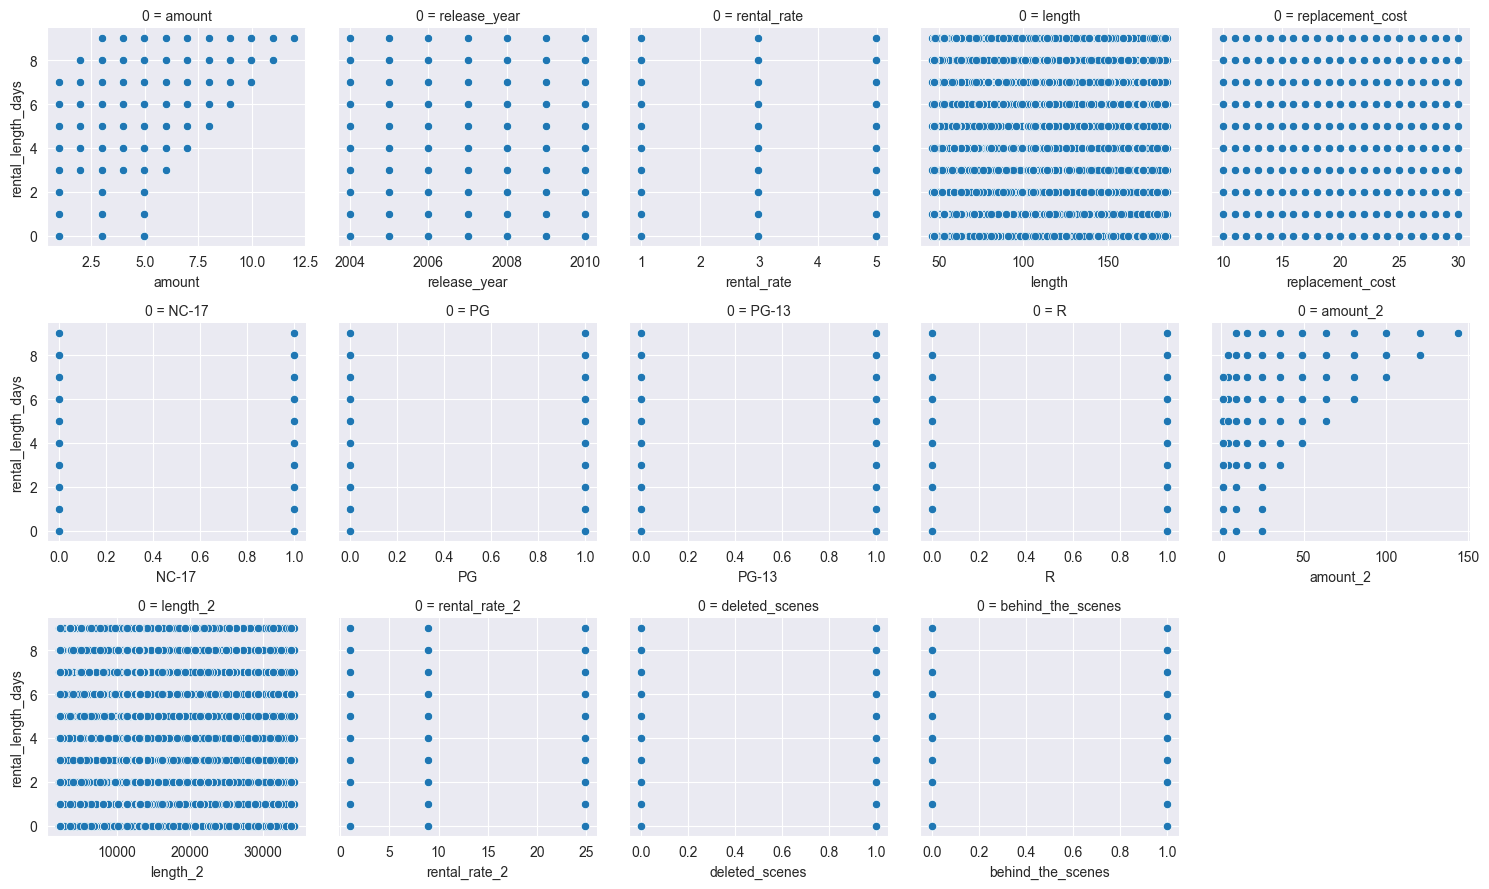

In [8]:
#Visualize the relationship between each feature and rental duration
features_names = [*X.columns]
g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=5, sharex=False)
for ax, x_var in zip(g.axes, features_names):
    sns.scatterplot(data=data, x=x_var, y='rental_length_days', ax=ax)
g.tight_layout()
plt.show()

In [9]:
data.corr()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,deleted_scenes,behind_the_scenes,rental_length_days
amount,1.000000,0.021726,0.685870,0.018947,-0.026725,0.003968,-0.010591,0.012773,-0.007029,0.956141,0.017864,0.678597,-0.010035,-0.014005,0.551593
release_year,0.021726,1.000000,0.037304,0.031088,0.069991,0.027187,-0.022237,0.027442,-0.052645,0.015941,0.030640,0.025106,0.010470,-0.002617,0.007044
rental_rate,0.685870,0.037304,1.000000,0.055224,-0.064787,0.036280,0.000174,0.022812,-0.033648,0.587627,0.053390,0.982489,-0.046163,-0.000578,-0.001060
length,0.018947,0.031088,0.055224,1.000000,0.026976,-0.030133,-0.049304,0.057023,0.068685,0.015765,0.987667,0.051516,-0.000409,0.006011,-0.004547
replacement_cost,-0.026725,0.069991,-0.064787,0.026976,1.000000,-0.001685,-0.077158,0.044224,0.017768,-0.018281,0.029747,-0.065835,0.046730,0.014281,0.015684
NC-17,0.003968,0.027187,0.036280,-0.030133,-0.001685,1.000000,-0.254017,-0.272206,-0.252767,0.001186,-0.029444,0.038815,0.024747,0.030828,0.000783
PG,-0.010591,-0.022237,0.000174,-0.049304,-0.077158,-0.254017,1.000000,-0.268408,-0.249240,-0.012859,-0.053299,-0.001420,0.057976,-0.022736,-0.008066
PG-13,0.012773,0.027442,0.022812,0.057023,0.044224,-0.272206,-0.268408,1.000000,-0.267087,0.008954,0.062629,0.022525,-0.027855,-0.000388,0.010201
R,-0.007029,-0.052645,-0.033648,0.068685,0.017768,-0.252767,-0.249240,-0.267087,1.000000,-0.004797,0.059310,-0.033067,-0.041887,0.000771,-0.007961
amount_2,0.956141,0.015941,0.587627,0.015765,-0.018281,0.001186,-0.012859,0.008954,-0.004797,1.000000,0.014662,0.596622,0.002433,-0.007377,0.549412


In [10]:
X.var()

amount               5.571409e+00
release_year         4.100733e+00
rental_rate          2.721727e+00
length               1.609190e+03
replacement_cost     3.701243e+01
NC-17                1.628921e-01
PG                   1.601916e-01
PG-13                1.734913e-01
R                    1.592443e-01
amount_2             5.523987e+02
length_2             8.823656e+07
rental_rate_2        1.001059e+02
deleted_scenes       2.500086e-01
behind_the_scenes    2.486946e-01
dtype: float64

In [11]:
#Split data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=9)

In [12]:
#Performing feature selection
clf = Lasso(alpha=0.1, random_state=9)
clf.fit(X_train,y_train)
coefficients = clf.coef_
feature_names = X_train.columns

In [13]:
feature_importance = pd.DataFrame({'Feature':feature_names, 'Coefficient': coefficients.round(3)})
feature_importance.sort_values(by='Coefficient')

,Feature,Coefficient
11,rental_rate_2,-0.177
4,replacement_cost,-0.001
1,release_year,0.000
2,rental_rate,-0.000
3,length,0.000
5,NC-17,0.000
6,PG,0.000
7,PG-13,0.000
8,R,-0.000
10,length_2,0.000


In [14]:
columns_to_drop = feature_importance['Coefficient']!=0

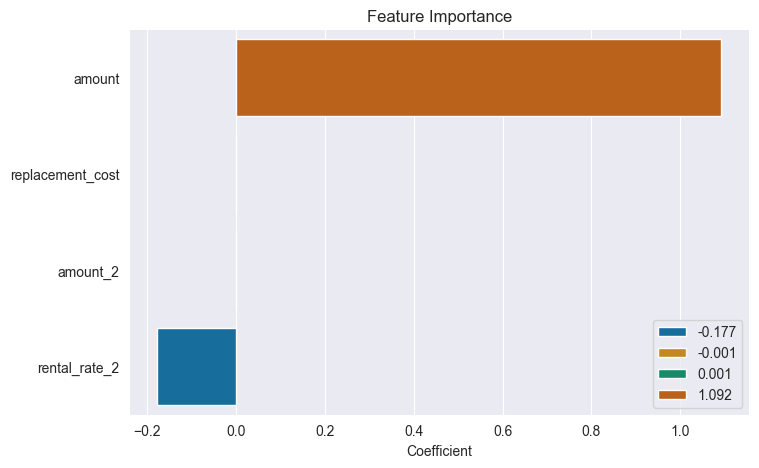

In [15]:
#Visualize feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance[columns_to_drop], hue='Coefficient', palette='colorblind', width=0.8, gap=0)
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.ylabel('')
sns.despine(top=True,right=True)
plt.legend(loc='lower right')
plt.show()

In [16]:
#Drop all the columns which Lasso coefficient is zero
X_train_reg = X_train[feature_importance[columns_to_drop]['Feature'].values]
X_test_reg = X_test[feature_importance[columns_to_drop]['Feature'].values]

In [17]:
lr = LinearRegression()
rf = RandomForestRegressor(random_state=9)
tr = DecisionTreeRegressor(random_state=9)
gbr = GradientBoostingRegressor(random_state=9)
svr = SVR()

In [18]:
models = {'Linear Regression': lr, 'Random Forest Regressor': rf ,  'Decision Tree Regressor': tr, 'GBRegressor': gbr,'SVR':svr}

In [19]:
model_scores = {}
models_list = []
for model_name,model in models.items():
    model.fit(X_train_reg,y_train)
    y_pred = model.predict(X_test_reg)
    mse_test = mean_squared_error(y_test,y_pred)
    y_pred_train = model.predict(X_train_reg)
    mse_train = mean_squared_error(y_train,y_pred_train)
    models_list.append(model)
    model_scores[model_name] = (mse_test,mse_train)

In [20]:
best_mse = 3
best_model = 'Unknown'
for key,(mse_test, mse_train) in model_scores.items():
    if mse_test < best_mse:
        best_mse = mse_test
        best_model = key
    print(f'MSE for {key} is {mse_test:.5f}')

MSE for Linear Regression is 3.09558
MSE for Random Forest Regressor is 2.54954
MSE for Decision Tree Regressor is 2.54939
MSE for GBRegressor is 2.51520
MSE for SVR is 2.65045


In [21]:
models_results = pd.DataFrame([{'Model_Name': model_name, 'MSE_Test': mse_test, 'MSE_Training': mse_training}
             for model_name, (mse_test, mse_training) in model_scores.items()])

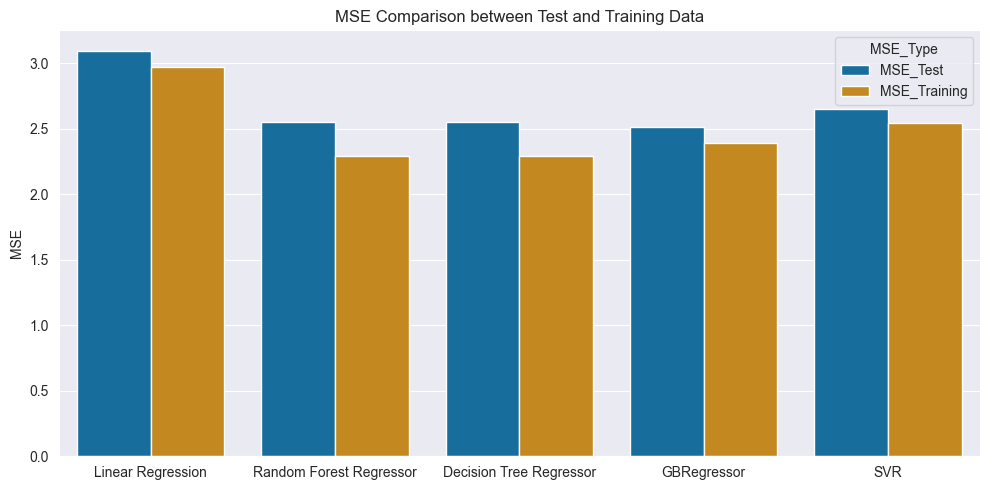

In [22]:
models_results_melted = models_results.melt(id_vars='Model_Name', var_name='MSE_Type', value_name='MSE')

plt.figure(figsize=(10, 5))
sns.barplot(data=models_results_melted, x='Model_Name', y='MSE', hue='MSE_Type', palette='colorblind')
plt.title('MSE Comparison between Test and Training Data')
plt.xlabel('')
plt.ylabel('MSE')
plt.xticks()
plt.tight_layout()
plt.show()

Despite comparable Mean Squared Error (MSE) scores between Random Forest and Decision Tree Regressor,
Gradient Boosting Regressor outperforms both models in terms of performance on both training and test datasets.

In [23]:
if best_model != 'Unknown':
    print(f'The best model is {best_model} with a mse of {best_mse:.3f}')

The best model is GBRegressor with a mse of 2.515


Since the mse score is less than 3, the requirements of the project are met

In [24]:
#Perform GridSearchCV to optimize hyperparameters for GradientBoostingRegressor model
gbr_a = GradientBoostingRegressor()
grid_params = {'n_estimators':[300], 'learning_rate':[0.05,0.1,0.2,0.25,0.5],
    'min_samples_leaf': [1, 2, 4], 'random_state': [9] }
grid = GridSearchCV(estimator=gbr_a, param_grid=grid_params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train_reg,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.25, 0.5],
                         'min_samples_leaf': [1, 2, 4], 'n_estimators': [300],
                         'random_state': [9]},
             scoring='neg_mean_squared_error')

In [25]:
grid.best_params_

{'learning_rate': 0.25,
 'min_samples_leaf': 2,
 'n_estimators': 300,
 'random_state': 9}

In [26]:
model_grid = GradientBoostingRegressor(**grid.best_params_)
model_grid.fit(X_train_reg,y_train)
y_pred_gbr = model_grid.predict(X_test_reg)
model_mse = mean_squared_error(y_test,y_pred_gbr)
print(f"The mse score is {model_mse:.3f}")

The mse score is 2.509


Despite conducting GridSearch to optimize model performance,  we only managed to achieve a marginal improvement mse of less than 1%.